In [1]:
import pandas as pd

In [2]:
pr_review_comments_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_review_comments.parquet")
pr_reviews_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_reviews.parquet")

C:\Users\gnand\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cell below: We obtain the total number of PR's that have had a PR review, this is used later for comparing proportion of code issue PR's

In [29]:
totalPRCount = float(pr_reviews_df['pr_id'].nunique())
totalPRCount

8140.0

Cell Below: We want to get the PR review states to see which states are considered problematic (or have possible code issues). The only 2 states we see to possibly have issues are 'CHANGES_REQUESTED' and 'COMMENTED'. The changes requested is assumed to have significant guaranteed code problems and the commented state is considered to possibly have code problems.

In [30]:
all_PR_review_states = pr_reviews_df['state'].unique()
print(all_PR_review_states)

['COMMENTED' 'APPROVED' 'CHANGES_REQUESTED' 'DISMISSED']


Cell below: We get the count of all PR's (all PR's that have been reviewed) that have significant code issues.

In [31]:
changes_requested_df = pr_reviews_df.query('state == "CHANGES_REQUESTED"')
changesRequestedPRCount = float(changes_requested_df['pr_id'].nunique())
changesRequestedPRCount

988.0

Cell below: We get the count of all PR's (all PR's that have been reviewed) that have possible code issues.

In [32]:
commented_state_df = pr_reviews_df.query('state == "COMMENTED"')
commented_state_df = commented_state_df[~commented_state_df['pr_id'].isin(changes_requested_df['pr_id'])]
commented_state_count = float(commented_state_df['pr_id'].nunique())
commented_state_count

5120.0

In [33]:
code_issue_keywords = ["incorrect", "error", "syntax", "bug", "fix", "inconsisten", "naming", "convention", "style", "efficient", "optimize", "optimization"]

# Function used to check if a given string matches any of the code-issue related keywords
def keywords_matched(string) :
    if string is None:
        return False

    string = str(string).lower()
    if any(sub in string for sub in code_issue_keywords) :
        return True

    return False

Cell below: We get the count of all PR's (all PR's that have been reviewed) with minor code issues. This is done by finding all PR's that had a review in a commented state with a body or pr review comments that text match "code-issue" like keywords.

In [34]:
pr_review_comments_with_comment_state = pr_review_comments_df[pr_review_comments_df['pull_request_review_id'].isin(commented_state_df['id'])]
pr_reviews_comments_with_comment_issues = pr_review_comments_with_comment_state[pr_review_comments_with_comment_state['body'].apply(keywords_matched)]
commented_state_with_issues_df = commented_state_df[commented_state_df['id'].isin(pr_reviews_comments_with_comment_issues['pull_request_review_id'])]
commented_state_with_issues_df2 = commented_state_df[commented_state_df['body'].apply(keywords_matched)]
commented_state_with_issues_df = pd.concat([commented_state_with_issues_df, commented_state_with_issues_df2])
commented_state_with_issues_count = float(commented_state_with_issues_df['pr_id'].nunique())
commented_state_with_issues_count

2706.0

Cell below: We get the count of all imperfect PR's (PR's that either had a review with a commented or changes requested state).

In [35]:
all_possible_issue_PRs_df = pd.concat([changes_requested_df, commented_state_df])
all_possible_issue_PRs_count = float(all_possible_issue_PRs_df['pr_id'].nunique())
all_possible_issue_PRs_count

6108.0

In [36]:
commented_state_with_possible_issues_count =  commented_state_count - commented_state_with_issues_count

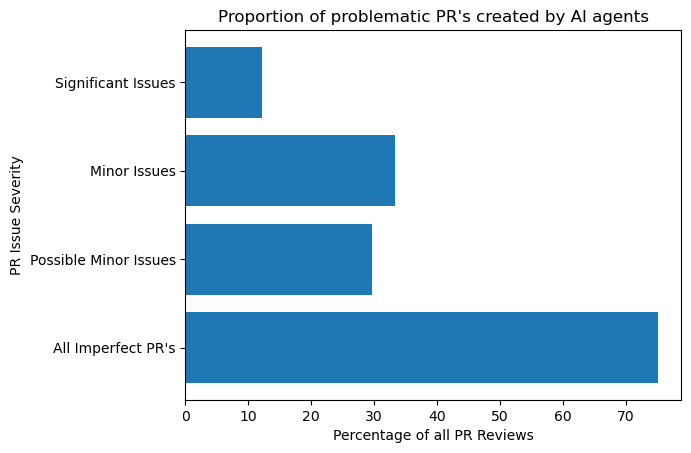

In [37]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline 

categories = np.array(["All Imperfect PR's", "Possible Minor Issues", "Minor Issues", "Significant Issues"])
values = np.array([all_possible_issue_PRs_count/totalPRCount*100, 
                   commented_state_with_possible_issues_count/totalPRCount*100, 
                  commented_state_with_issues_count/totalPRCount*100, 
                    changesRequestedPRCount/totalPRCount*100])

plt.barh(categories, values)

plt.title("Proportion of problematic PR's created by AI agents")
plt.xlabel("Percentage of all PR Reviews")
plt.ylabel("PR Issue Severity")

plt.show()

In [38]:
print(all_possible_issue_PRs_count/totalPRCount*100)
print(commented_state_with_possible_issues_count/totalPRCount*100)
print(commented_state_with_issues_count/totalPRCount*100)
print(changesRequestedPRCount/totalPRCount*100)

75.03685503685503
29.656019656019655
33.24324324324324
12.137592137592138


From the results we see that approximately 12.14% of AI Agents PR's contain significant code issues, 33.24% contain minor issues, 29.66% possibly contain minor issues, and 75.04% of their PR's are not perfect and required some form of reconsideration before merging (includes all other 3 categories).  
The first 3 categories are disjoint while the last one is the union of the first 3.  
From this, we know that 12.14%+33.24% = 45.38% of PR's contain some form of code issues (mostly minor).

Cell below: Configuring variables for code issue keywords, dictionary for keywords matching code issue categories, dictionary count of each category (in # of PR's), and dictionary of lists of matching PR Ids for each category.

In [39]:
issue_types = {"incorrect": "errors or wrong implementations", "error": "errors or wrong implementations", "syntax": "errors or wrong implementations", "issue": "errors or wrong implementations", "bug": "errors or wrong implementations", "fix": "errors or wrong implementations", "inconsisten": "code style and conventions", "naming": "code style and conventions", "convention": "code style and conventions", "style": "code style and conventions", "efficient":"code quality, code structure or efficiency", "optimize":"code quality, code structure or efficiency", "optimization":"code quality, code structure or efficiency"}
issue_counts = {"errors or wrong implementations": 0, "code style and conventions":0, "code quality, code structure or efficiency": 0}
issue_PR_id_lists = {"errors or wrong implementations": set(), "code style and conventions":set(), "code quality, code structure or efficiency": set()}

Function below: **Check_And_Add_To_Issue_Category**  
**parameter matching_pr_ids** - list of pull request id's matching a code issue category  
**parameter issue_type** - the string name of the code-issue category  
**return value: None**
For each pull request ID, this function checks if the category has already been detected for that PR ID. If it has already been detected it is skipped. If it has not been detected then the PR ID is added to the dictionary list for that category and the count of that categories matches is increased by 1

In [40]:
#parameter matching_pr_ids - list of pull request id's matching a code issue category
#parameter issue_type - the string name of the code-issue category
#return value: None
#For each pull request ID, this function checks if the category has already been 
#detected for that PR ID. If it has already been detected it is skipped. If it has
#not been detected then the PR ID is added to the dictionary list for that category and
# the count of that categories matches is increased by 1
def Check_And_Add_To_Issue_Category(matching_pr_ids, issue_type):
    for pr_id in matching_pr_ids :
        if not pr_id in issue_PR_id_lists[issue_type] :
            issue_PR_id_lists[issue_type].add(pr_id)
            issue_counts[issue_type] = issue_counts[issue_type] + 1
    

The code below matches all PR's to certain code-issue categories to determine the amount of PR's that have a code issue fitting to each category.

In [41]:
problematic_PR_review_comments_df = pr_review_comments_df[pr_review_comments_df['pull_request_review_id'].isin(all_possible_issue_PRs_df['id'])]

for keyword in code_issue_keywords : 
    matching_pr_review_comments = problematic_PR_review_comments_df[problematic_PR_review_comments_df['body'].str.lower().str.find(keyword) != -1]
    matching_pr_reviews = all_possible_issue_PRs_df[all_possible_issue_PRs_df['id'].isin(matching_pr_review_comments['pull_request_review_id'])]
    matching_pr_ids = matching_pr_reviews['pr_id'].drop_duplicates().tolist()

    issue_type = issue_types[keyword]
    Check_And_Add_To_Issue_Category(matching_pr_ids, issue_type)

    matching_pr_reviews = all_possible_issue_PRs_df[all_possible_issue_PRs_df['body'].str.lower().str.find(keyword) != -1]
    matching_pr_ids = matching_pr_reviews['pr_id'].drop_duplicates().tolist()
    
    Check_And_Add_To_Issue_Category(matching_pr_ids, issue_type)

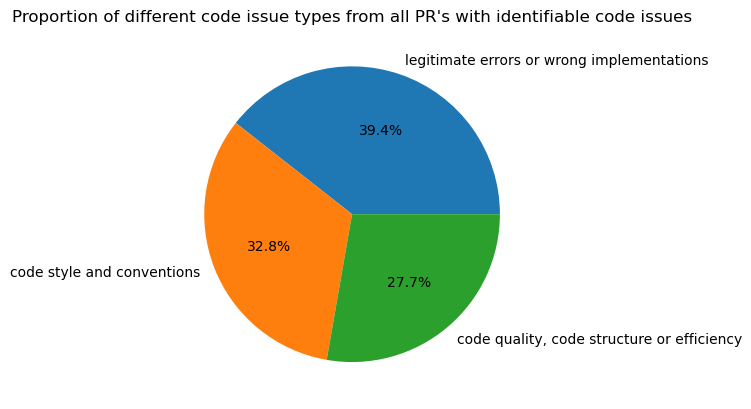

In [78]:
import matplotlib.pyplot as plt

labels = "legitimate errors or wrong implementations", "code style and conventions", "code quality, code structure or efficiency"
sizes = [issue_counts["errors or wrong implementations"], issue_counts["code style and conventions"], issue_counts["code quality, code structure or efficiency"]]

plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Proportion of different code issue types from all PR's with identifiable code issues")
plt.show()
